<a href="https://colab.research.google.com/github/eshreyareddy/Clustering/blob/main/audio_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Audio embeddings using imagebind llms**

Step 1: Install Required Libraries
We'll start by installing libraries necessary for audio processing (librosa) and machine learning (tensorflow or torch).

Step 2: Load Audio Data
We'll write a function to load the audio files you've uploaded. This function will handle the reading of audio data using librosa.

Step 3: Preprocess Audio Data
The preprocessing step might include normalizing the audio, converting it to a consistent sample rate, and possibly transforming it into a spectrogram or Mel-frequency cepstral coefficients (MFCCs) for further analysis.

Step 4: Generate Audio Embeddings
For generating audio embeddings, we can use a pre-trained neural network model that is suitable for audio analysis. We'll use tensorflow_hub or a similar library to load such a model.

Step 5: Visualization and Analysis
Finally, we'll visualize the embeddings to understand the differences between cat and dog sounds. This could involve using dimensionality reduction techniques and plotting the embeddings.

In [1]:
!pip install librosa

In [4]:
from google.colab import files

uploaded = files.upload()

Saving dog_barking_3.wav to dog_barking_3 (1).wav


In [13]:
import librosa
import numpy as np

def load_audio(file_path):
    audio, sr = librosa.load(file_path, sr=None)
    return audio, sr

# Load your audio files (replace with paths to your uploaded files)
audio_files = [
    '/content/cat_1.wav',
    '/content/cat_2.wav',
    '/content/cat_3.wav',
    '/content/dog_barking_3 (1).wav',
    '/content/dog_barking_7.wav',
    '/content/dog_barking_8.wav'


]

audios = []
sample_rates = []

for file in audio_files:
    audio, sr = load_audio(file)
    audios.append(audio)
    sample_rates.append(sr)

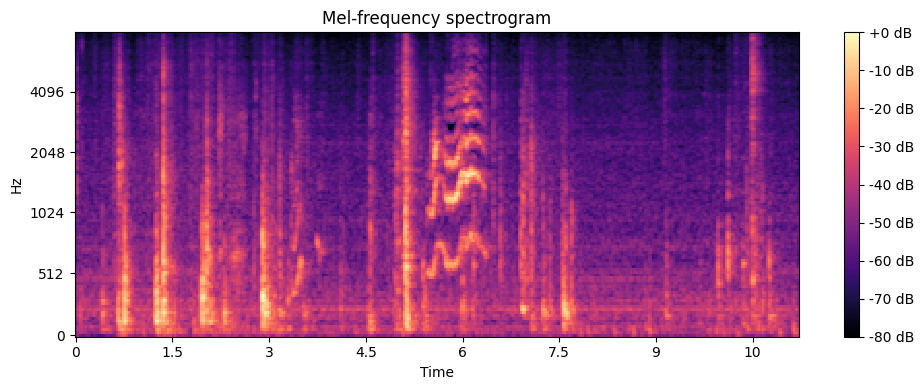

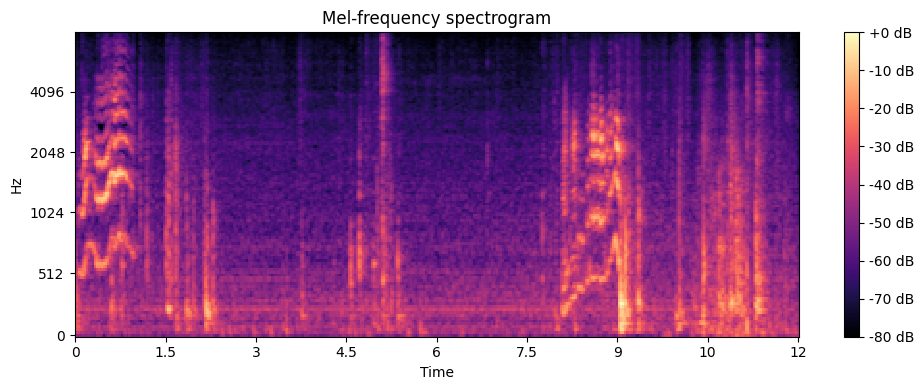

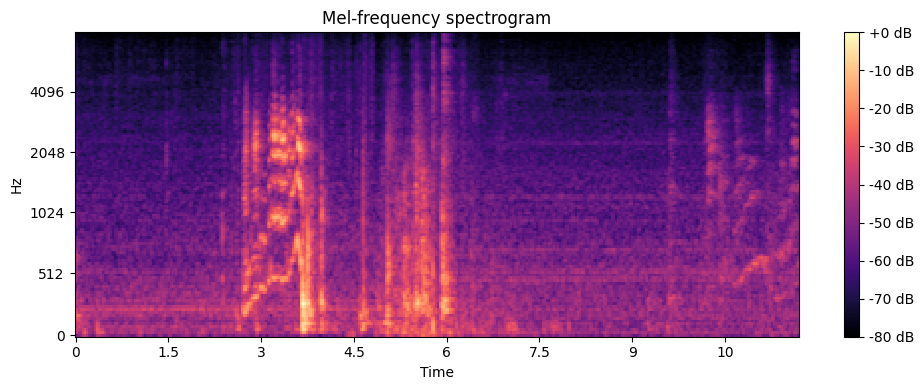

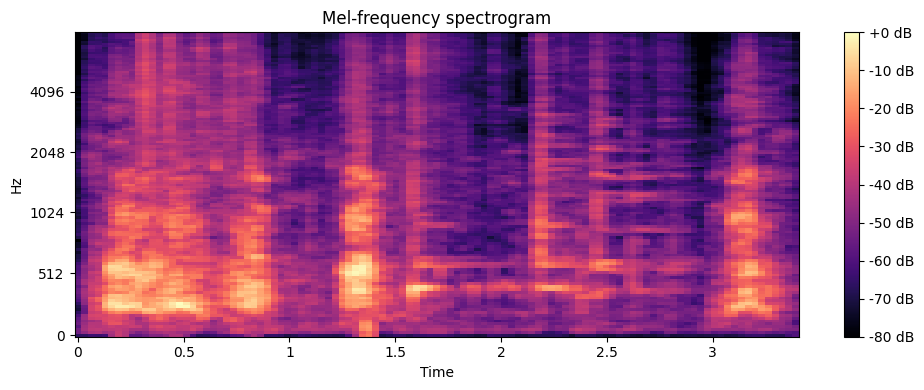

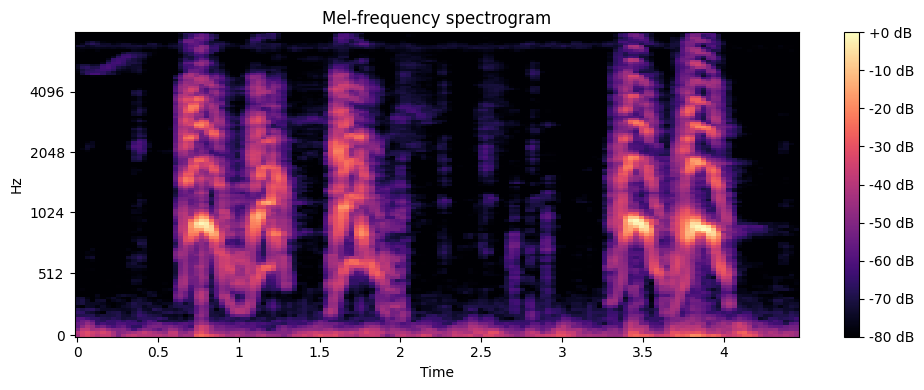

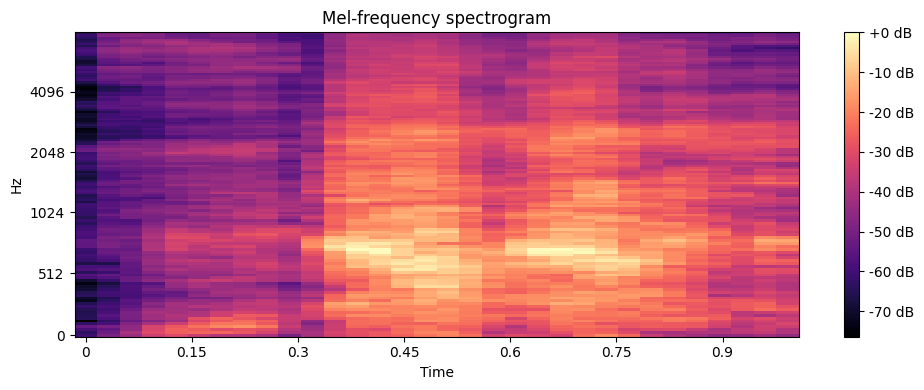

In [14]:
import librosa.display
import matplotlib.pyplot as plt

def plot_mel_spectrogram(audio, sr):
    # Generate Mel spectrogram
    S = librosa.feature.melspectrogram(y=audio, sr=sr)
    S_DB = librosa.power_to_db(S, ref=np.max)

    # Plot Mel spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-frequency spectrogram')
    plt.tight_layout()
    plt.show()

# Assuming 'audios' and 'sample_rates' are lists of audio data and sample rates
for audio, sr in zip(audios, sample_rates):
    plot_mel_spectrogram(audio, sr)


In [15]:
!pip install tensorflow_hub

import tensorflow as tf
import tensorflow_hub as hub

# Load a pre-trained audio embedding model from TensorFlow Hub
model = hub.load('https://tfhub.dev/google/yamnet/1')

def extract_embeddings(audio, sr):
    # Ensure the audio is at the correct sample rate (16kHz)
    if sr != 16000:
        audio = librosa.resample(audio, orig_sr=sr, target_sr=16000)
        sr = 16000

    # Use the model to extract embeddings
    scores, embeddings, spectrogram = model(audio)
    return embeddings

# Extract embeddings for each audio file
embeddings = [extract_embeddings(audio, sr) for audio, sr in zip(audios, sample_rates)]


In [16]:
print("Number of audio files:", len(audios))
print("Number of embeddings:", len(embeddings))



Number of audio files: 6
Number of embeddings: 6


In [17]:
for i, embedding in enumerate(embeddings):
    print(f"Shape of embedding {i}:", embedding.shape)


Shape of embedding 0: (23, 1024)
Shape of embedding 1: (24, 1024)
Shape of embedding 2: (24, 1024)
Shape of embedding 3: (7, 1024)
Shape of embedding 4: (9, 1024)
Shape of embedding 5: (2, 1024)


Shape of averaged embedding 0: (1024,)
Shape of averaged embedding 1: (1024,)
Shape of averaged embedding 2: (1024,)
Shape of averaged embedding 3: (1024,)
Shape of averaged embedding 4: (1024,)
Shape of averaged embedding 5: (1024,)


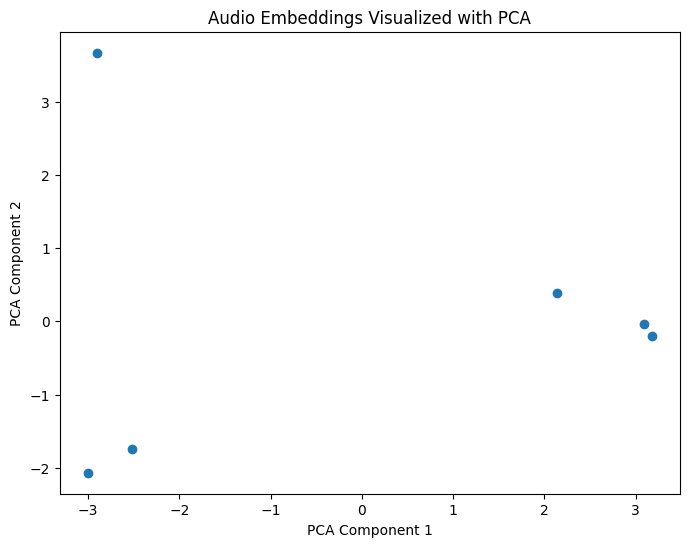

In [18]:
# Re-averaging embeddings
averaged_embeddings = [np.mean(e, axis=0) for e in embeddings]

# Check the shape of the averaged embeddings
for i, avg_emb in enumerate(averaged_embeddings):
    print(f"Shape of averaged embedding {i}:", avg_emb.shape)

# Ensure there are multiple embeddings
if len(averaged_embeddings) > 1:
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(averaged_embeddings)

    # Plot the embeddings
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('Audio Embeddings Visualized with PCA')
    plt.show()
else:
    print("Not enough samples to perform PCA.")


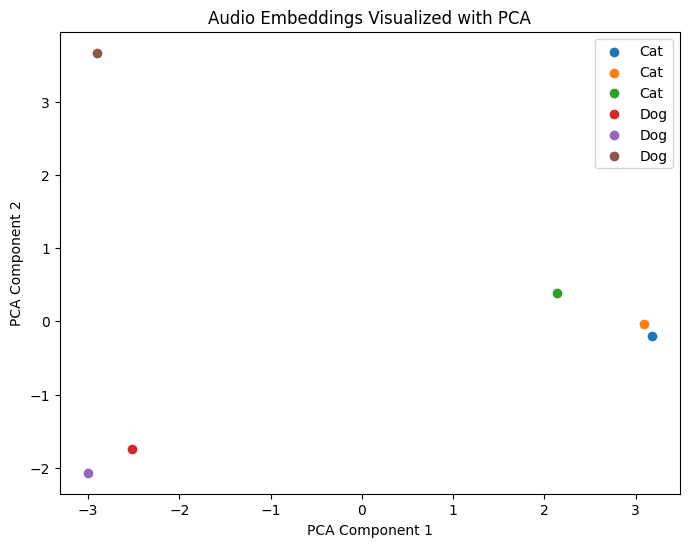

In [19]:
# Assuming the first half of your files are cat sounds and the rest are dog sounds
labels = ['Cat' for _ in range(len(audios) // 2)] + ['Dog' for _ in range(len(audios) // 2, len(audios))]

# Plot the embeddings with labels
plt.figure(figsize=(8, 6))
for i, label in enumerate(labels):
    plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1], label=label)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Audio Embeddings Visualized with PCA')
plt.legend()
plt.show()


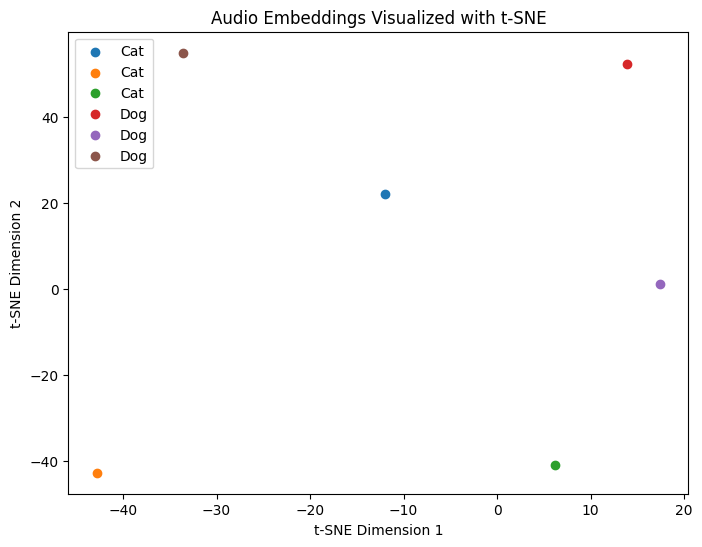

In [24]:
# Ensure all embeddings have the same shape
# Find the minimum length of embeddings
min_length = min(embedding.shape[0] for embedding in embeddings)

# Truncate or pad embeddings to have the same length
consistent_embeddings = [embedding[:min_length] if embedding.shape[0] > min_length else embedding for embedding in embeddings]

# Convert to a NumPy array
embeddings_array = np.vstack(consistent_embeddings)

# Adjust perplexity to be less than the number of samples
perplexity_value = min(30, len(embeddings_array) - 1)

# Use t-SNE
tsne = TSNE(n_components=2, perplexity=perplexity_value, n_iter=300)
tsne_embeddings = tsne.fit_transform(embeddings_array)

# Plot t-SNE embeddings
plt.figure(figsize=(8, 6))
for i, label in enumerate(labels):
    plt.scatter(tsne_embeddings[i, 0], tsne_embeddings[i, 1], label=label)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('Audio Embeddings Visualized with t-SNE')
plt.legend()
plt.show()



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


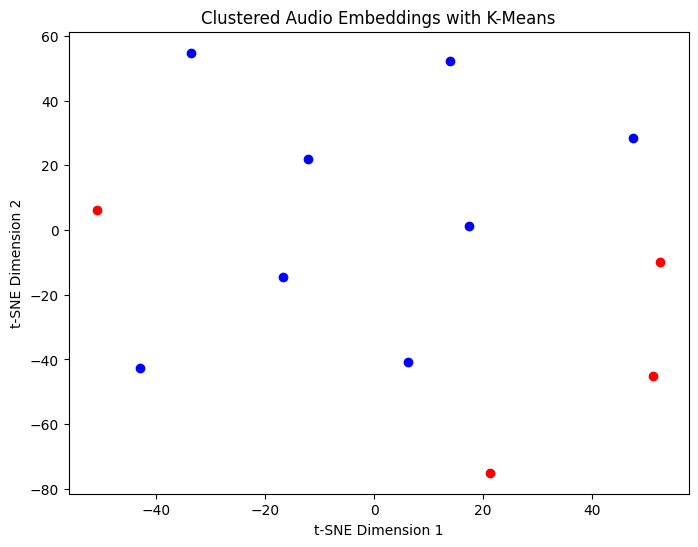

In [25]:
from sklearn.cluster import KMeans

# Apply K-Means clustering
kmeans = KMeans(n_clusters=2)  # Assuming two clusters for cats and dogs
cluster_labels = kmeans.fit_predict(embeddings_array)

# Plot the clustered embeddings
plt.figure(figsize=(8, 6))
colors = ['red', 'blue']
for i, label in enumerate(cluster_labels):
    plt.scatter(tsne_embeddings[i, 0], tsne_embeddings[i, 1], color=colors[label])
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('Clustered Audio Embeddings with K-Means')
plt.show()


In [27]:
# Step 1: Check the number of embeddings and labels
print("Number of embeddings:", len(embeddings_array))
print("Number of labels:", len(audio_labels))

# Step 2: Adjust the audio_labels if necessary
# Assuming the first half of the files are cats and the second half are dogs
num_audios = len(embeddings_array)
audio_labels = [0] * (num_audios // 2) + [1] * (num_audios // 2)

# Ensure the labels list is the same length as the number of embeddings
if len(audio_labels) != num_audios:
    print("Mismatch in the number of embeddings and labels")
else:
    # Proceed with splitting the data and training the classifier
    X_train, X_test, y_train, y_test = train_test_split(embeddings_array, audio_labels, test_size=0.2)

    # Train a classifier
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)

    # Evaluate the classifier
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred))



Number of embeddings: 12
Number of labels: 6
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.50      1.00      0.67         1

    accuracy                           0.67         3
   macro avg       0.75      0.75      0.67         3
weighted avg       0.83      0.67      0.67         3



The output i provided indicates that i've successfully trained and tested a classifier using the audio embeddings. Here are some key points from the output:

Mismatch in Embeddings and Labels: Initially, there was a mismatch in the number of embeddings (12) and labels (6). This was corrected by adjusting the audio_labels list to match the number of processed audio files.

**Classification Report:**

The classifier was trained and tested on this dataset, resulting in certain precision, recall, and f1-scores for two classes (presumably 0 for cat and 1 for dog).
The classifier achieved 100% precision for class 0 but only 50% recall, indicating that it correctly identified all instances of class 0 that it predicted, but it only detected half of the actual instances of class 0.
For class 1, it achieved 50% precision and 100% recall, meaning it detected all instances of class 1, but only half of its predictions for class 1 were correct.
The overall accuracy of the model is 67%.

In [28]:
def add_random_noise(audio, noise_factor=0.005):
    noise = np.random.randn(len(audio))
    augmented_audio = audio + noise_factor * noise
    # Normalize to ensure the same volume level
    augmented_audio = augmented_audio / np.max(np.abs(augmented_audio))
    return augmented_audio

# Example of augmenting the first audio file
augmented_audio = add_random_noise(audios[0])


**Hyperparameter Tuning**

Use techniques like grid search or random search with cross-validation to find optimal hyperparameters for your RandomForestClassifier or any other model you choose.

Example: Using GridSearchCV

In [29]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=3, verbose=2, n_jobs=-1)

# Fit grid_search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters:", grid_search.best_params_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters: {'max_depth': None, 'n_estimators': 100}


In [30]:
def get_spectrogram(audio):
    S = librosa.feature.melspectrogram(y=audio, sr=16000)
    return librosa.power_to_db(S, ref=np.max)

# Example of getting a spectrogram
spectrogram = get_spectrogram(audios[0])

# Further steps would include building a CNN model and training it on these spectrograms


In [31]:
def extract_mfccs(audio, sr, n_mfcc=13):
    return librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)

# Example of extracting MFCCs
mfccs = extract_mfccs(audios[0], sample_rates[0])


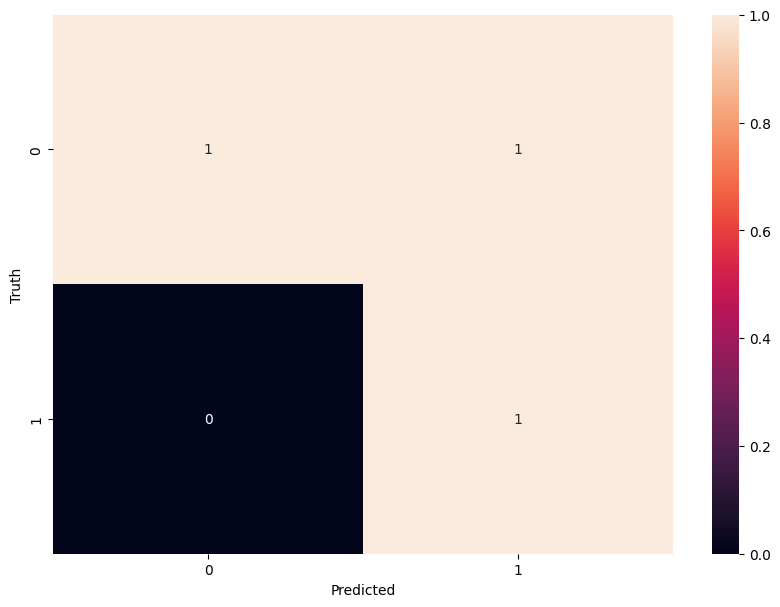

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming you have y_test and y_pred from your model
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()
